In [22]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import yaml
import open3d as o3d
from tqdm.notebook import tqdm
import random

random.seed(42)
np.random.seed(42)
cv2.setRNGSeed(42)

# Add the project directory to the Python path
sys.path.append('..')

# Import project modules
from src.preprocessing.image_loader import load_image_sequence, resize_images
from src.preprocessing.image_preprocessing import enhance_contrast
from src.feature_extraction.sift_extractor import extract_features_from_image_set
from src.feature_extraction.orb_extractor import extract_distributed_orb_features, extract_orb_features
from src.feature_extraction.feature_matcher import match_image_pairs, geometric_verification
from src.sfm.camera_calibration import estimate_camera_matrix
from src.sfm.pose_estimation import estimate_poses_incremental, force_loop_closure
from src.sfm.triangulation import triangulate_all_points, merge_triangulated_points
from src.sfm.bundle_adjustment import run_global_ba
from src.dense_reconstruction.mvs import process_mvs
from src.dense_reconstruction.point_cloud import process_dense_reconstruction, create_surface_mesh, save_mesh
from src.surface_reconstruction.mesh_generation import process_point_cloud_to_mesh, clean_mesh
from src.surface_reconstruction.texture_mapping import create_textured_mesh_from_point_cloud


from src.visualization.plot_matches import plot_matches, plot_feature_matching_analysis
from src.visualization.point_cloud_visualizer import plot_interactive_point_cloud, create_point_cloud_animation
from src.visualization.camera_visualizer import plot_interactive_camera_poses
from src.visualization.mesh_visualizer import visualize_mesh_o3d, plot_interactive_mesh

# Set up matplotlib for inline display
%matplotlib inline
# For newer matplotlib versions (3.6+)
plt.style.use('default')

In [23]:
# Define configuration
config = {
    "preprocessing": {
        "resize_max_dimension": 1000,
        "enhance_contrast": True
    },
    "features": {
        "method": "sift",
        "max_features": 50000,
        "use_multiscale": True,
        "use_dense": True,
        "dense_step": 5,
        "contrast_threshold": 0.01,
        "edge_threshold": 8
    },
    "matching": {
        "ratio_threshold": 0.7,
        "geometric_verification": True,
        "min_matches": 10,
        "verification_method": "fundamental",
        "ransac_threshold": 2.0,
        "cross_check": True,
        "max_epipolar_error": 1.0,
        "confidence": 0.999
    },
    "calibration": {
        "focal_length_factor": 1.3,
        "principal_point": "center",
        "refine_intrinsics": True
    },
    "sfm": {
        "incremental": True,
        "refine_poses": True,
        "min_triangulation_angle_deg": 2.0,
        "reprojection_error_threshold": 2.0,
        "bundle_adjustment_max_iterations": 100,
        "max_reprojection_error": 3.0,
        "merge_threshold": 0.001
    },
    "mvs": {
        "min_disparity": 0,
        "num_disparities": 128,
        "block_size": 7,
        "filter_depths": True,
        "consistency_threshold": 0.01,
        "num_source_views": 5
    },
    "point_cloud": {
        "voxel_size": 0.02,
        "nb_neighbors": 30,
        "std_ratio": 1.5,
        "confidence_threshold": 0.8
    },
    "surface": {
        "method": "poisson",
        "depth": 10,
        "cleanup": True,
        "trim": 7.0
    },
    "visualization": {
        "point_size": 2,
        "camera_size": 6,
        "point_color_method": "rgb"
    }
}

# Create output directory for results
output_dir = "../data/results/"
os.makedirs(output_dir, exist_ok=True)

print("Configuration loaded with 50,000 maximum features and strict quality filtering.")

Configuration loaded with 50,000 maximum features and strict quality filtering.


Loading black background images for feature extraction...
Loaded 36 black background images.
Loading original background images for depth estimation...
Loaded 36 original background images.
Resized images to maximum dimension of 1000 pixels.
Enhanced image contrast.


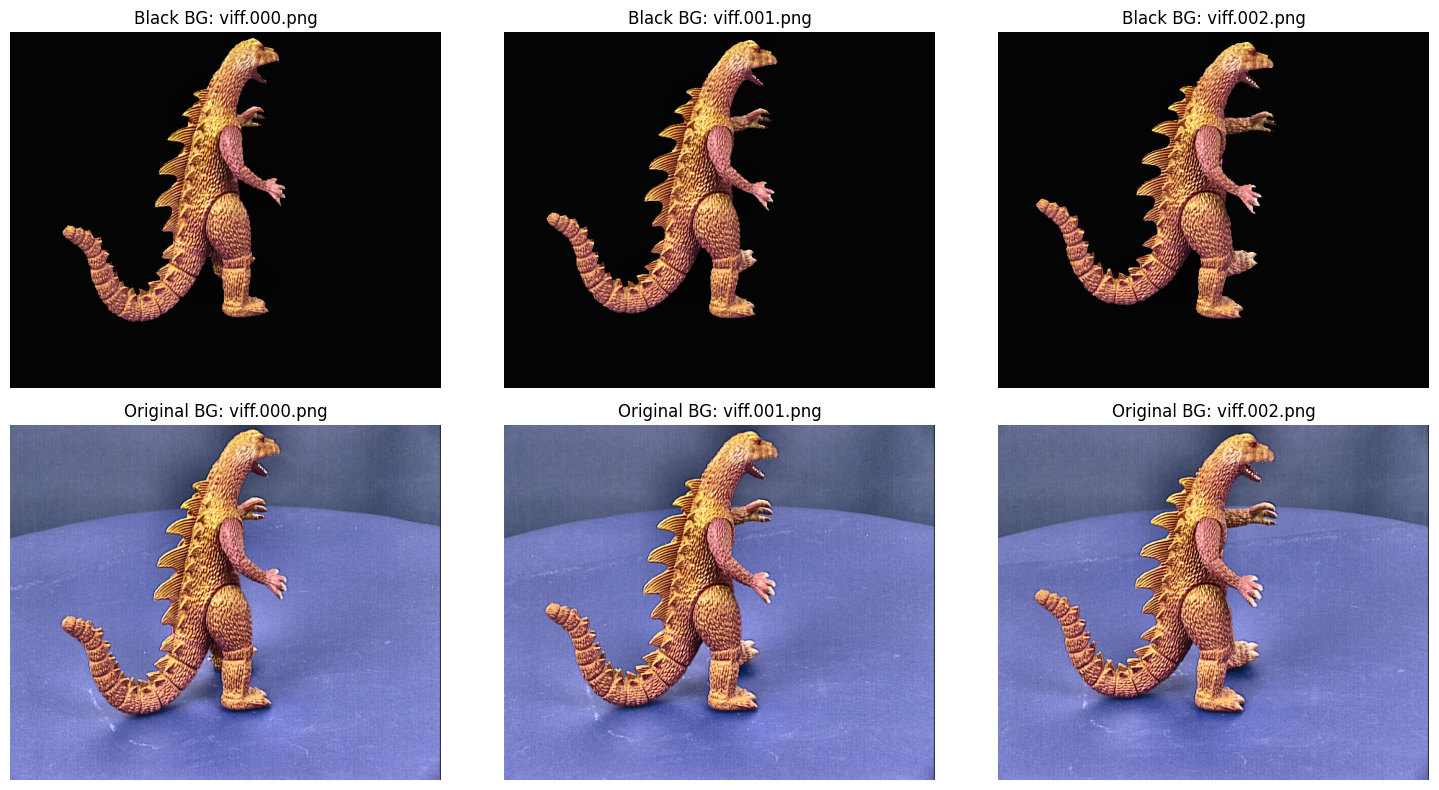

In [24]:
# Define paths to both datasets
dataset_path_black = '../data/dinosaur_cropped_black/'  # Black background
dataset_path_original = '../data/dinosaur_cropped/'       # Original background

# Load black background images for feature extraction and matching
print("Loading black background images for feature extraction...")
black_images = load_image_sequence(dataset_path_black, pattern="viff.*.png")
print(f"Loaded {len(black_images)} black background images.")

# Also load original background images for depth estimation
print("Loading original background images for depth estimation...")
original_images = load_image_sequence(dataset_path_original, pattern="viff.*.png")
print(f"Loaded {len(original_images)} original background images.")

# Make sure image lists are the same length and in the same order
if len(black_images) != len(original_images):
    print("Warning: Different number of images in the two datasets")
    # Keep only matching filenames
    black_filenames = [filename for _, filename in black_images]
    original_filenames = [filename for _, filename in original_images]
    common_filenames = set(black_filenames).intersection(set(original_filenames))
    
    black_images = [(img, filename) for img, filename in black_images if filename in common_filenames]
    original_images = [(img, filename) for img, filename in original_images if filename in common_filenames]
    
    print(f"Using {len(black_images)} images that exist in both datasets")

# Resize black background images
max_dim = config['preprocessing']['resize_max_dimension']
black_images = resize_images(black_images, max_dimension=max_dim)
original_images = resize_images(original_images, max_dimension=max_dim)
print(f"Resized images to maximum dimension of {max_dim} pixels.")

# Enhance contrast if specified
if config['preprocessing']['enhance_contrast']:
    black_images = enhance_contrast(black_images)
    original_images = enhance_contrast(original_images)
    print("Enhanced image contrast.")

# Display a comparison between black and original images
n_images = min(3, len(black_images))
fig, axes = plt.subplots(2, n_images, figsize=(15, 8))

for i in range(n_images):
    img_black, filename_black = black_images[i]
    axes[0, i].imshow(img_black)
    axes[0, i].set_title(f"Black BG: {filename_black}")
    axes[0, i].axis('off')
    
    img_orig, filename_orig = original_images[i]
    axes[1, i].imshow(img_orig)
    axes[1, i].set_title(f"Original BG: {filename_orig}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [25]:
def filter_matches_on_black_background(matches_dict, images):
    """
    Filter out matches where either keypoint is on a black background.
    
    Args:
        matches_dict: Dictionary of matches from match_image_pairs
        images: List of (image, filename) tuples
        
    Returns:
        Filtered matches dictionary
    """
    # Create a mapping from filename to image for quick lookup
    image_dict = {filename: img for img, filename in images}
    
    # Create masks for each image (non-black regions)
    mask_dict = {}
    for filename, img in image_dict.items():
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
        # Create binary mask - pixels with value > 15 are considered part of the dinosaur
        _, mask = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        mask_dict[filename] = mask
    
    filtered_matches_dict = {}
    
    # For each image pair in the matches dictionary
    for (img1_name, img2_name), (kp1, kp2, matches) in matches_dict.items():
        mask1 = mask_dict[img1_name]
        mask2 = mask_dict[img2_name]
        
        # Filter matches - keep only those where both points are on non-black areas
        filtered_matches = []
        for m in matches:
            # Get keypoint coordinates (need to round to integers for mask indexing)
            x1, y1 = int(round(kp1[m.queryIdx].pt[0])), int(round(kp1[m.queryIdx].pt[1]))
            x2, y2 = int(round(kp2[m.trainIdx].pt[0])), int(round(kp2[m.trainIdx].pt[1]))
            
            # Check if coordinates are within image bounds
            h1, w1 = mask1.shape
            h2, w2 = mask2.shape
            
            if (0 <= x1 < w1 and 0 <= y1 < h1 and 0 <= x2 < w2 and 0 <= y2 < h2):
                # Check if both points are on the dinosaur (non-black regions)
                if mask1[y1, x1] > 0 and mask2[y2, x2] > 0:
                    filtered_matches.append(m)
        
        # If we have enough matches after filtering, keep this pair
        if len(filtered_matches) >= 8:  # Use 8 as minimum for fundamental matrix estimation
            filtered_matches_dict[(img1_name, img2_name)] = (kp1, kp2, filtered_matches)
            print(f"Filtered {img1_name}-{img2_name}: {len(matches)} → {len(filtered_matches)} matches")
    
    print(f"Filtered matches: {len(matches_dict)} pairs → {len(filtered_matches_dict)} pairs")
    return filtered_matches_dict


Extracting comprehensive features from black background images...
Using enhanced SIFT extraction with target of 50000 features per image
viff.000.png: Extracted 17231 keypoints
viff.001.png: Extracted 17261 keypoints
viff.002.png: Extracted 17494 keypoints
viff.003.png: Extracted 17762 keypoints
viff.004.png: Extracted 17413 keypoints
viff.005.png: Extracted 16605 keypoints
viff.006.png: Extracted 16036 keypoints
viff.007.png: Extracted 15125 keypoints
viff.008.png: Extracted 14572 keypoints
viff.009.png: Extracted 13686 keypoints
viff.010.png: Extracted 12699 keypoints
viff.011.png: Extracted 12461 keypoints
viff.012.png: Extracted 12472 keypoints
viff.013.png: Extracted 12261 keypoints
viff.014.png: Extracted 12111 keypoints
viff.015.png: Extracted 12989 keypoints
viff.016.png: Extracted 13628 keypoints
viff.017.png: Extracted 15088 keypoints
viff.018.png: Extracted 16100 keypoints
viff.019.png: Extracted 16714 keypoints
viff.020.png: Extracted 16857 keypoints
viff.021.png: Extracte

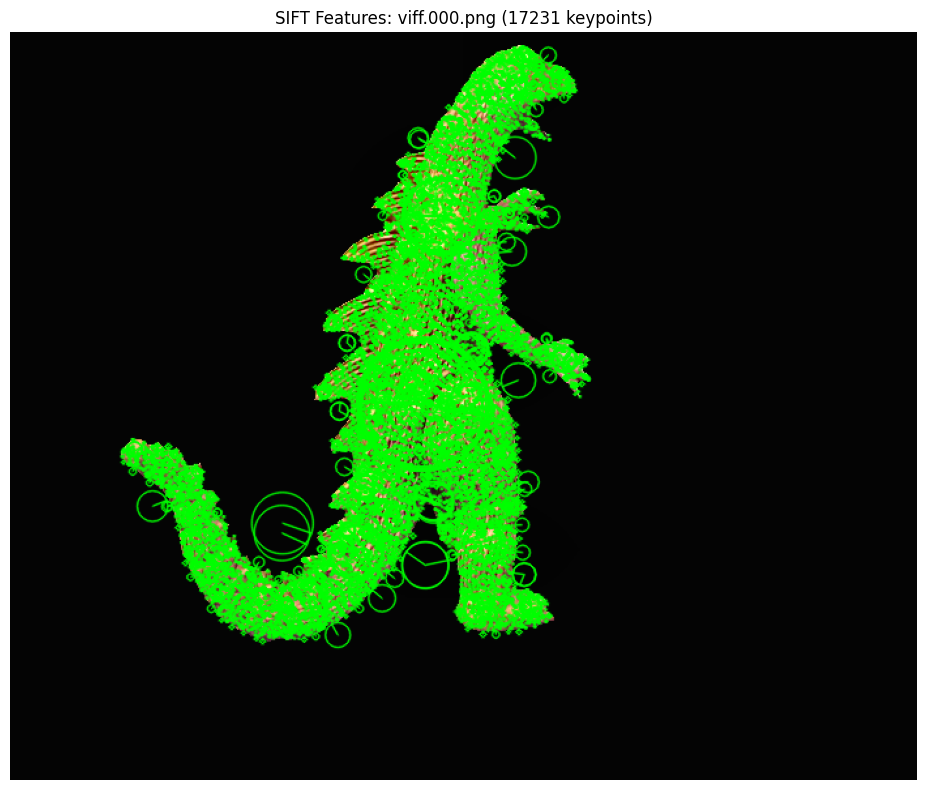


Creating optimized view graph for circular object reconstruction...
Creating view graph for 36 images
Created 71 image pairs for matching
Found 71 valid image pairs with 15461 total matches
Filtered viff.000.png-viff.001.png: 291 → 271 matches
Filtered viff.001.png-viff.000.png: 274 → 257 matches
Filtered viff.001.png-viff.002.png: 307 → 278 matches
Filtered viff.002.png-viff.001.png: 318 → 287 matches
Filtered viff.002.png-viff.003.png: 299 → 276 matches
Filtered viff.003.png-viff.002.png: 312 → 288 matches
Filtered viff.003.png-viff.004.png: 293 → 274 matches
Filtered viff.004.png-viff.003.png: 296 → 277 matches
Filtered viff.004.png-viff.005.png: 249 → 233 matches
Filtered viff.005.png-viff.004.png: 263 → 246 matches
Filtered viff.005.png-viff.006.png: 243 → 235 matches
Filtered viff.006.png-viff.005.png: 220 → 215 matches
Filtered viff.006.png-viff.007.png: 237 → 230 matches
Filtered viff.007.png-viff.006.png: 205 → 196 matches
Filtered viff.007.png-viff.008.png: 207 → 201 matches

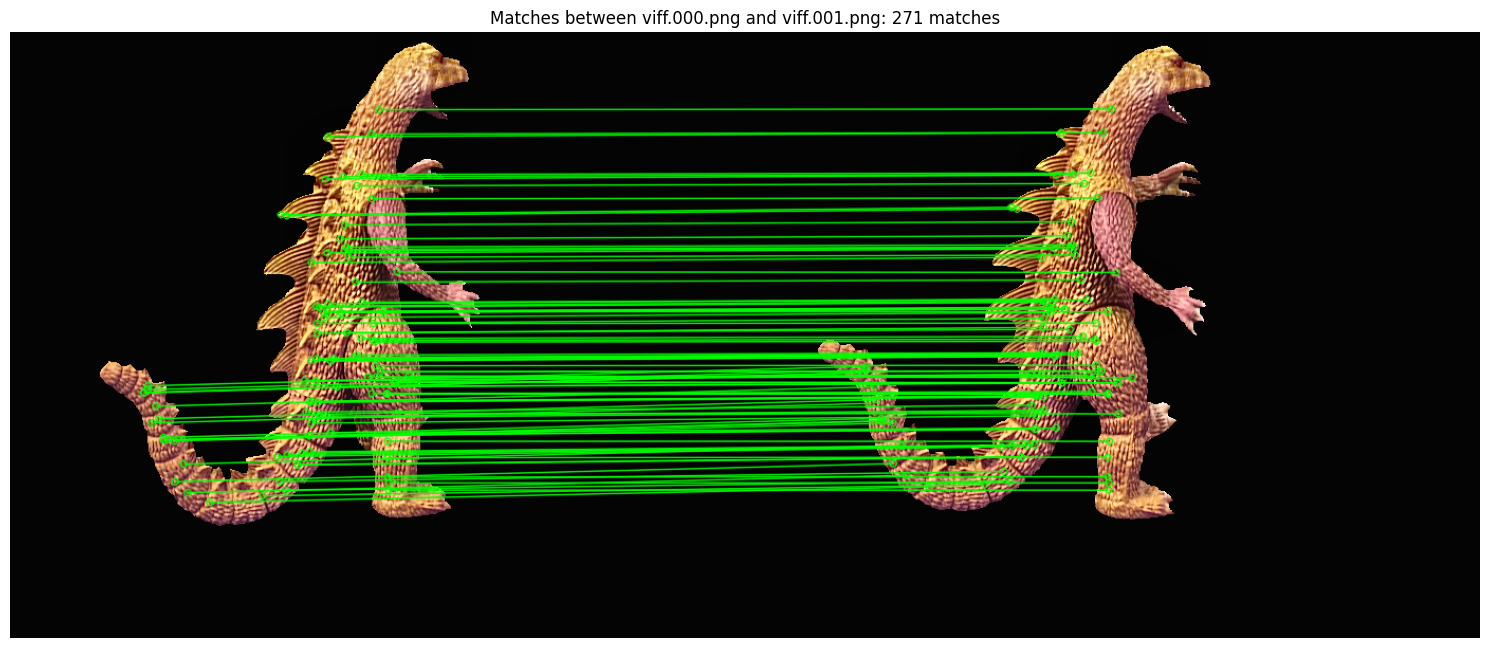

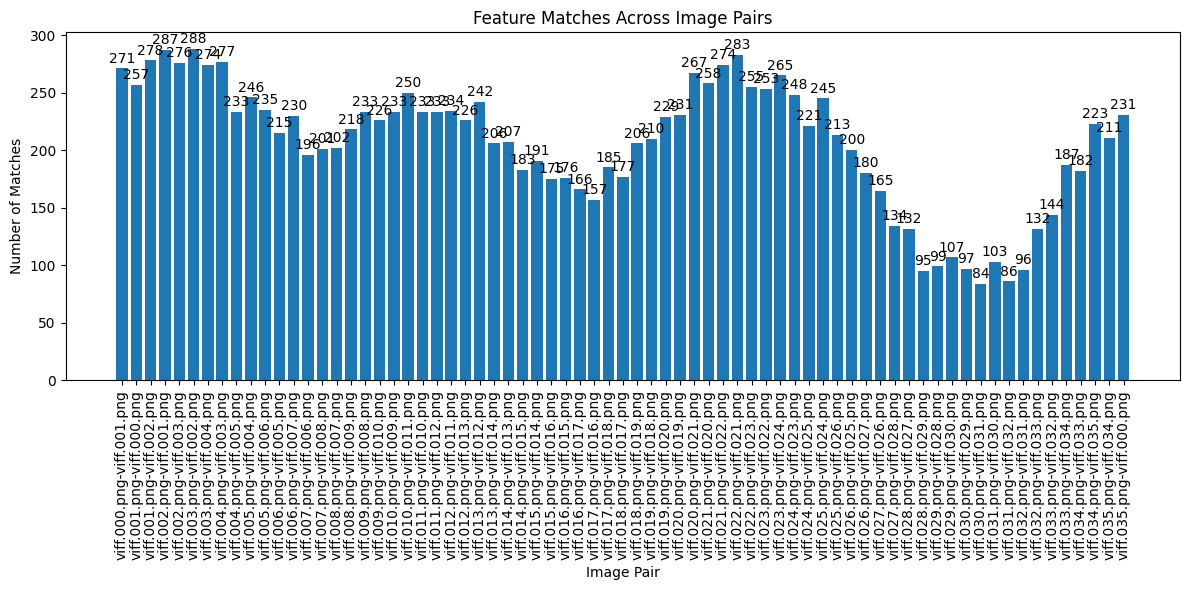

In [26]:
# Extract features from black background images with enhanced strategies
print("\nExtracting comprehensive features from black background images...")
feature_method = config['features']['method']
max_features = config['features']['max_features']  # Triple the feature count

# Set SIFT extraction parameters if using SIFT
if feature_method.lower() == 'sift':
    print(f"Using enhanced SIFT extraction with target of {max_features} features per image")
    
    # Extract features using enhanced extraction methods
    features_dict = extract_features_from_image_set(black_images, method=feature_method, n_features=max_features, contrast_threshold=config['features']['contrast_threshold'])
else:
    # For other methods, use standard extraction
    features_dict = extract_features_from_image_set(black_images, method=feature_method, n_features=max_features, contrast_threshold=config['features']['contrast_threshold'])

# Print feature counts
total_features = 0
for filename, (keypoints, descriptors) in features_dict.items():
    print(f"{filename}: {len(keypoints)} keypoints")
    total_features += len(keypoints)

print(f"Total features extracted: {total_features} (avg {total_features/len(features_dict):.0f} per image)")

# Visualize keypoints on a sample image
sample_img, sample_filename = black_images[0]
sample_keypoints, _ = features_dict[sample_filename]

# Plot keypoints
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.drawKeypoints(sample_img, sample_keypoints, None, 
                          color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax.set_title(f"{feature_method.upper()} Features: {sample_filename} ({len(sample_keypoints)} keypoints)")
ax.axis('off')
plt.tight_layout()
plt.show()

# Create image pairs for matching with a comprehensive circular strategy
print("\nCreating optimized view graph for circular object reconstruction...")
filenames = sorted([filename for _, filename in black_images], 
                  key=lambda x: int(''.join(filter(str.isdigit, x))))

# Number of images
n = len(filenames)
print(f"Creating view graph for {n} images")

# Create image pairs for matching with a comprehensive circular strategy
image_pairs = []

# 1. Keep sequential pairs as your foundation
for i in range(n-1):
    image_pairs.append((filenames[i], filenames[i+1]))
image_pairs.append((filenames[-1], filenames[0]))  # Close the loop
# Remove duplicates while preserving order
seen = set()
image_pairs = [x for x in image_pairs if not (x in seen or seen.add(x))]

print(f"Created {len(image_pairs)} image pairs for matching")

# Match features
matches_dict = match_image_pairs(
    features_dict, 
    image_pairs, 
    ratio_threshold=config['matching']['ratio_threshold'],
    geometric_verify=config['matching']['geometric_verification'],
    min_matches=config['matching']['min_matches']
)

matches_dict = filter_matches_on_black_background(matches_dict, black_images)


print(f"Successfully matched {len(matches_dict)} image pairs.")

# Display matches for a sample pair
if len(matches_dict) > 0:
    # Choose a sample pair
    sample_pair = list(matches_dict.keys())[0]
    img1_name, img2_name = sample_pair
    kp1, kp2, matches = matches_dict[sample_pair]
    
    # Get the images
    img1 = next(img for img, filename in black_images if filename == img1_name)
    img2 = next(img for img, filename in black_images if filename == img2_name)
    
    # Plot matches
    plot_matches(img1, kp1, img2, kp2, matches[:100],  # Only plot first 100 matches for clarity
                title=f"Matches between {img1_name} and {img2_name}: {len(matches)} matches")

    # Show matching statistics across all pairs
    plot_feature_matching_analysis(matches_dict, figsize=(12, 6))

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import random
import cv2
import os

import numpy as np

def enforce_perfect_circle(camera_poses):
    # Get ordered filenames
    filenames = sorted(list(camera_poses.keys()), 
                      key=lambda x: int(''.join(filter(str.isdigit, x))))
    
    # Calculate average circle center and radius
    centers = []
    for name in filenames:
        R, t = camera_poses[name]
        center = -R.T @ t
        centers.append(center)
    
    centers = np.array(centers)
    circle_center = np.mean(centers, axis=0)
    
    # Calculate average radius
    radii = np.linalg.norm(centers - circle_center, axis=1)
    avg_radius = np.mean(radii)
    
    # Force cameras into perfect circle
    corrected_poses = {}
    n_cameras = len(filenames)
    
    for i, name in enumerate(filenames):
        R, _ = camera_poses[name]
        
        # Calculate perfect circle position
        angle = 2 * np.pi * i / n_cameras
        x = circle_center[0] + avg_radius * np.cos(angle)
        y = circle_center[1] + avg_radius * np.sin(angle)
        z = circle_center[2]  # Keep same height
        
        new_center = np.array([x, y, z])
        new_t = -R @ new_center
        
        corrected_poses[name] = (R, new_t)
    
    return corrected_poses


# Dictionary to store camera poses for each parameter combination
all_camera_poses = {}

# Estimate camera intrinsics (same for all runs)
sample_img, _ = black_images[0]
image_shape = sample_img.shape
focal_length_factor = config['calibration']['focal_length_factor']
focal_length = 1.3 * max(image_shape[0], image_shape[1])
K = estimate_camera_matrix(image_shape, focal_length)
print("Estimated camera matrix:")
print(K)

# Run matching with essential matrix

# Run for each parameter combination and show interactive plot immediately
#for i in range(50):
random.seed(47)
np.random.seed(47)
cv2.setRNGSeed(47)
print("RUN", i)
matches_dict = match_image_pairs(
    features_dict, 
    image_pairs, 
    ratio_threshold=0.75,
    geometric_verify=config['matching']['geometric_verification'],
    min_matches=config['matching']['min_matches']
)
matches_dict = filter_matches_on_black_background(matches_dict, black_images)


# Estimate camera poses
camera_poses = estimate_poses_incremental(matches_dict, K, 8)

print(f"Estimated poses for {len(camera_poses)} cameras.")

# Show the interactive plot immediately for this parameter combination
if len(camera_poses) > 0:
    print("Displaying interactive 3D plot...")
    plot_interactive_camera_poses(camera_poses)
else:
    print("No camera poses were estimated with these parameters. Skipping plot.")

#camera_poses = enforce_perfect_circle(camera_poses)

plot_interactive_camera_poses(camera_poses)

# Print summary table at the end
print("\nSummary of results:")
print("-" * 60)
print(f"{'Ratio':<10} {'Seed':<10} {'NumCameras':<15}")
print("-" * 60)
for (ratio, seed), poses in all_camera_poses.items():
    print(f"{ratio:<10} {seed:<10} {len(poses):<15}")

Estimated camera matrix:
[[903.5   0.  347.5]
 [  0.  903.5 286.5]
 [  0.    0.    1. ]]
RUN 34
Found 71 valid image pairs with 20578 total matches
Filtered viff.000.png-viff.001.png: 360 → 335 matches
Filtered viff.001.png-viff.000.png: 366 → 344 matches
Filtered viff.001.png-viff.002.png: 411 → 375 matches
Filtered viff.002.png-viff.001.png: 426 → 386 matches
Filtered viff.002.png-viff.003.png: 422 → 393 matches
Filtered viff.003.png-viff.002.png: 393 → 368 matches
Filtered viff.003.png-viff.004.png: 378 → 357 matches
Filtered viff.004.png-viff.003.png: 368 → 351 matches
Filtered viff.004.png-viff.005.png: 340 → 324 matches
Filtered viff.005.png-viff.004.png: 340 → 323 matches
Filtered viff.005.png-viff.006.png: 333 → 322 matches
Filtered viff.006.png-viff.005.png: 327 → 317 matches
Filtered viff.006.png-viff.007.png: 314 → 301 matches
Filtered viff.007.png-viff.006.png: 284 → 274 matches
Filtered viff.007.png-viff.008.png: 269 → 262 matches
Filtered viff.008.png-viff.007.png: 275 → 


Summary of results:
------------------------------------------------------------
Ratio      Seed       NumCameras     
------------------------------------------------------------


In [ ]:
# Triangulate 3D points
print("\nTriangulating 3D points...")
points_3d, point_observations = triangulate_all_points(camera_poses, matches_dict, K)

print(f"Triangulated {len(points_3d)} 3D points.")

# Merge close points to reduce noise
merged_points, merged_observations = merge_triangulated_points(points_3d, point_observations, threshold=0.1)
print(f"After merging: {len(merged_points)} 3D points.")

# Bundle adjustment to refine camera poses and 3D points
if config['sfm']['refine_poses'] and len(merged_points) > 0:
    print("\nRunning bundle adjustment...")
    refined_poses, refined_points, _ = run_global_ba(camera_poses, matches_dict, K, iterations=50)
    points_3d = refined_points
    print("Bundle adjustment complete.")
    plot_interactive_camera_poses(refined_poses)

# Visualize sparse point cloud
if len(points_3d) > 0:
    print("\nVisualizing sparse point cloud...")
    points_array = np.array(points_3d)
    
    # Assign random colors for visualization
    np.random.seed(42)  # For reproducibility
    colors = np.random.rand(len(points_array), 3)
    
    # Interactive visualization
    plot_interactive_point_cloud(points_array, colors, title="Sparse 3D Reconstruction")

    # Save sparse point cloud
    sparse_cloud_file = os.path.join(output_dir, "dinosaur_sparse.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_array)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(sparse_cloud_file, pcd)
    print(f"Saved sparse point cloud to {sparse_cloud_file}")




Triangulating 3D points...
Triangulating from 36 camera poses and 71 feature matches
Found 71 valid image pairs for triangulation
Triangulated 19309 3D points
Triangulated 19309 3D points.
Merged 19309 points into 842 points
After merging: 842 3D points.

Visualizing sparse point cloud...


Saved sparse point cloud to ../data/results/dinosaur_sparse.ply



Running Multi-View Stereo with hybrid approach...
Starting enhanced Multi-View Stereo processing...
Using configuration optimized for challenging objects:
  - min_disparity: 0
  - num_disparities: 128
  - block_size: 7
  - filter_depths: True
  - consistency_threshold: 0.01
  - num_source_views: 5


Computing depth maps:   0%|          | 0/36 [00:00<?, ?it/s]

Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:   3%|▎         | 1/36 [00:09<05:37,  9.63s/it]

Computed depth map for viff.000.png using source views: ['viff.002.png', 'viff.035.png', 'viff.003.png', 'viff.001.png', 'viff.034.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:   6%|▌         | 2/36 [00:18<05:10,  9.14s/it]

Computed depth map for viff.001.png using source views: ['viff.003.png', 'viff.004.png', 'viff.002.png', 'viff.000.png', 'viff.035.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:   8%|▊         | 3/36 [00:27<04:58,  9.05s/it]

Computed depth map for viff.002.png using source views: ['viff.004.png', 'viff.000.png', 'viff.005.png', 'viff.003.png', 'viff.001.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  11%|█         | 4/36 [00:36<04:52,  9.14s/it]

Computed depth map for viff.003.png using source views: ['viff.001.png', 'viff.005.png', 'viff.000.png', 'viff.006.png', 'viff.004.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  14%|█▍        | 5/36 [00:45<04:36,  8.93s/it]

Computed depth map for viff.004.png using source views: ['viff.002.png', 'viff.006.png', 'viff.007.png', 'viff.001.png', 'viff.003.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  17%|█▋        | 6/36 [00:54<04:34,  9.14s/it]

Computed depth map for viff.005.png using source views: ['viff.003.png', 'viff.007.png', 'viff.008.png', 'viff.002.png', 'viff.006.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  19%|█▉        | 7/36 [01:02<04:13,  8.75s/it]

Computed depth map for viff.006.png using source views: ['viff.004.png', 'viff.008.png', 'viff.009.png', 'viff.003.png', 'viff.007.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  22%|██▏       | 8/36 [01:10<03:59,  8.54s/it]

Computed depth map for viff.007.png using source views: ['viff.005.png', 'viff.009.png', 'viff.004.png', 'viff.010.png', 'viff.006.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  25%|██▌       | 9/36 [01:19<03:51,  8.59s/it]

Computed depth map for viff.008.png using source views: ['viff.010.png', 'viff.006.png', 'viff.005.png', 'viff.011.png', 'viff.009.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  28%|██▊       | 10/36 [01:27<03:37,  8.38s/it]

Computed depth map for viff.009.png using source views: ['viff.011.png', 'viff.007.png', 'viff.006.png', 'viff.012.png', 'viff.008.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  31%|███       | 11/36 [01:36<03:33,  8.52s/it]

Computed depth map for viff.010.png using source views: ['viff.012.png', 'viff.008.png', 'viff.007.png', 'viff.011.png', 'viff.013.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  33%|███▎      | 12/36 [01:45<03:31,  8.82s/it]

Computed depth map for viff.011.png using source views: ['viff.009.png', 'viff.013.png', 'viff.010.png', 'viff.008.png', 'viff.014.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  36%|███▌      | 13/36 [01:56<03:37,  9.47s/it]

Computed depth map for viff.012.png using source views: ['viff.010.png', 'viff.014.png', 'viff.009.png', 'viff.015.png', 'viff.013.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  39%|███▉      | 14/36 [02:06<03:30,  9.58s/it]

Computed depth map for viff.013.png using source views: ['viff.015.png', 'viff.011.png', 'viff.014.png', 'viff.016.png', 'viff.010.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  42%|████▏     | 15/36 [02:16<03:22,  9.65s/it]

Computed depth map for viff.014.png using source views: ['viff.012.png', 'viff.016.png', 'viff.017.png', 'viff.013.png', 'viff.011.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  44%|████▍     | 16/36 [02:24<03:05,  9.29s/it]

Computed depth map for viff.015.png using source views: ['viff.013.png', 'viff.017.png', 'viff.012.png', 'viff.018.png', 'viff.016.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  47%|████▋     | 17/36 [02:32<02:48,  8.88s/it]

Computed depth map for viff.016.png using source views: ['viff.018.png', 'viff.014.png', 'viff.013.png', 'viff.015.png', 'viff.019.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  50%|█████     | 18/36 [02:41<02:36,  8.70s/it]

Computed depth map for viff.017.png using source views: ['viff.015.png', 'viff.019.png', 'viff.014.png', 'viff.018.png', 'viff.020.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  53%|█████▎    | 19/36 [02:48<02:23,  8.44s/it]

Computed depth map for viff.018.png using source views: ['viff.016.png', 'viff.020.png', 'viff.017.png', 'viff.021.png', 'viff.019.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  56%|█████▌    | 20/36 [02:57<02:17,  8.62s/it]

Computed depth map for viff.019.png using source views: ['viff.017.png', 'viff.021.png', 'viff.022.png', 'viff.018.png', 'viff.016.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  58%|█████▊    | 21/36 [03:05<02:04,  8.28s/it]

Computed depth map for viff.020.png using source views: ['viff.018.png', 'viff.022.png', 'viff.023.png', 'viff.019.png', 'viff.021.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  61%|██████    | 22/36 [03:14<01:58,  8.49s/it]

Computed depth map for viff.021.png using source views: ['viff.019.png', 'viff.023.png', 'viff.024.png', 'viff.018.png', 'viff.020.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  64%|██████▍   | 23/36 [03:21<01:45,  8.13s/it]

Computed depth map for viff.022.png using source views: ['viff.020.png', 'viff.024.png', 'viff.025.png', 'viff.019.png', 'viff.023.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  67%|██████▋   | 24/36 [03:29<01:38,  8.19s/it]

Computed depth map for viff.023.png using source views: ['viff.021.png', 'viff.025.png', 'viff.020.png', 'viff.026.png', 'viff.022.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  69%|██████▉   | 25/36 [03:38<01:31,  8.35s/it]

Computed depth map for viff.024.png using source views: ['viff.026.png', 'viff.022.png', 'viff.021.png', 'viff.027.png', 'viff.025.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  72%|███████▏  | 26/36 [03:46<01:22,  8.28s/it]

Computed depth map for viff.025.png using source views: ['viff.027.png', 'viff.023.png', 'viff.022.png', 'viff.026.png', 'viff.028.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  75%|███████▌  | 27/36 [03:55<01:14,  8.29s/it]

Computed depth map for viff.026.png using source views: ['viff.028.png', 'viff.024.png', 'viff.023.png', 'viff.029.png', 'viff.025.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  78%|███████▊  | 28/36 [04:03<01:07,  8.40s/it]

Computed depth map for viff.027.png using source views: ['viff.025.png', 'viff.029.png', 'viff.030.png', 'viff.024.png', 'viff.026.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  81%|████████  | 29/36 [04:11<00:57,  8.27s/it]

Computed depth map for viff.028.png using source views: ['viff.026.png', 'viff.030.png', 'viff.031.png', 'viff.025.png', 'viff.027.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  83%|████████▎ | 30/36 [04:19<00:48,  8.13s/it]

Computed depth map for viff.029.png using source views: ['viff.027.png', 'viff.031.png', 'viff.032.png', 'viff.026.png', 'viff.028.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  86%|████████▌ | 31/36 [04:29<00:43,  8.74s/it]

Computed depth map for viff.030.png using source views: ['viff.032.png', 'viff.028.png', 'viff.027.png', 'viff.033.png', 'viff.031.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  89%|████████▉ | 32/36 [04:40<00:37,  9.33s/it]

Computed depth map for viff.031.png using source views: ['viff.033.png', 'viff.029.png', 'viff.028.png', 'viff.034.png', 'viff.032.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  92%|█████████▏| 33/36 [04:51<00:29,  9.79s/it]

Computed depth map for viff.032.png using source views: ['viff.030.png', 'viff.034.png', 'viff.035.png', 'viff.029.png', 'viff.033.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  94%|█████████▍| 34/36 [05:01<00:19,  9.81s/it]

Computed depth map for viff.033.png using source views: ['viff.031.png', 'viff.035.png', 'viff.030.png', 'viff.032.png', 'viff.034.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps:  97%|█████████▋| 35/36 [05:17<00:11, 11.80s/it]

Computed depth map for viff.034.png using source views: ['viff.032.png', 'viff.031.png', 'viff.033.png', 'viff.035.png', 'viff.000.png']
Processing source view 1/5...
Processing source view 2/5...
Processing source view 3/5...
Processing source view 4/5...
Processing source view 5/5...


Computing depth maps: 100%|██████████| 36/36 [05:43<00:00,  9.55s/it]


Computed depth map for viff.035.png using source views: ['viff.033.png', 'viff.000.png', 'viff.032.png', 'viff.034.png', 'viff.001.png']


Consistency check:   0%|          | 0/36 [00:00<?, ?it/s]c:\Users\Eier\master_school_work\computer_vision\2Dto3D-Net\notebooks\..\src\dense_reconstruction\mvs.py:276: RuntimeWarning:

invalid value encountered in cast

c:\Users\Eier\master_school_work\computer_vision\2Dto3D-Net\notebooks\..\src\dense_reconstruction\mvs.py:277: RuntimeWarning:

invalid value encountered in cast

Consistency check:   3%|▎         | 1/36 [00:01<00:54,  1.55s/it]

viff.000.png: 2971/216422 pixels consistent (1.37%)


Consistency check:   6%|▌         | 2/36 [00:02<00:49,  1.46s/it]

viff.001.png: 3142/200961 pixels consistent (1.56%)


Consistency check:   8%|▊         | 3/36 [00:04<00:47,  1.45s/it]

viff.002.png: 2991/194929 pixels consistent (1.53%)


Consistency check:  11%|█         | 4/36 [00:05<00:46,  1.45s/it]

viff.003.png: 3524/204096 pixels consistent (1.73%)


Consistency check:  14%|█▍        | 5/36 [00:06<00:37,  1.22s/it]

viff.004.png: 2745/149418 pixels consistent (1.84%)


Consistency check:  17%|█▋        | 6/36 [00:08<00:47,  1.57s/it]

viff.005.png: 4381/214244 pixels consistent (2.04%)


Consistency check:  19%|█▉        | 7/36 [00:10<00:49,  1.70s/it]

viff.006.png: 4274/211930 pixels consistent (2.02%)


Consistency check:  22%|██▏       | 8/36 [00:11<00:36,  1.31s/it]

viff.007.png: 2974/157586 pixels consistent (1.89%)


Consistency check:  25%|██▌       | 9/36 [00:11<00:29,  1.10s/it]

viff.008.png: 3873/213202 pixels consistent (1.82%)


Consistency check:  28%|██▊       | 10/36 [00:12<00:22,  1.15it/s]

viff.009.png: 2774/152794 pixels consistent (1.82%)


Consistency check:  31%|███       | 11/36 [00:13<00:20,  1.24it/s]

viff.010.png: 3814/209649 pixels consistent (1.82%)


Consistency check:  33%|███▎      | 12/36 [00:13<00:16,  1.42it/s]

viff.011.png: 2877/155859 pixels consistent (1.85%)


Consistency check:  36%|███▌      | 13/36 [00:14<00:16,  1.40it/s]

viff.012.png: 3880/208892 pixels consistent (1.86%)


Consistency check:  39%|███▉      | 14/36 [00:14<00:15,  1.45it/s]

viff.013.png: 3642/208392 pixels consistent (1.75%)


Consistency check:  42%|████▏     | 15/36 [00:15<00:13,  1.60it/s]

viff.014.png: 2793/156049 pixels consistent (1.79%)


Consistency check:  44%|████▍     | 16/36 [00:16<00:13,  1.47it/s]

viff.015.png: 3872/213967 pixels consistent (1.81%)


Consistency check:  47%|████▋     | 17/36 [00:16<00:11,  1.64it/s]

viff.016.png: 2754/156574 pixels consistent (1.76%)


Consistency check:  50%|█████     | 18/36 [00:17<00:11,  1.62it/s]

viff.017.png: 3912/214604 pixels consistent (1.82%)


Consistency check:  53%|█████▎    | 19/36 [00:17<00:10,  1.60it/s]

viff.018.png: 3539/208274 pixels consistent (1.70%)


Consistency check:  56%|█████▌    | 20/36 [00:18<00:09,  1.71it/s]

viff.019.png: 2894/156233 pixels consistent (1.85%)


Consistency check:  58%|█████▊    | 21/36 [00:18<00:08,  1.68it/s]

viff.020.png: 3731/203255 pixels consistent (1.84%)


Consistency check:  61%|██████    | 22/36 [00:19<00:07,  1.90it/s]

viff.021.png: 3015/154087 pixels consistent (1.96%)


Consistency check:  64%|██████▍   | 23/36 [00:20<00:07,  1.74it/s]

viff.022.png: 3157/177220 pixels consistent (1.78%)


Consistency check:  67%|██████▋   | 24/36 [00:20<00:06,  1.92it/s]

viff.023.png: 2646/137851 pixels consistent (1.92%)


Consistency check:  69%|██████▉   | 25/36 [00:20<00:05,  1.95it/s]

viff.024.png: 3646/206980 pixels consistent (1.76%)


Consistency check:  72%|███████▏  | 26/36 [00:21<00:05,  1.89it/s]

viff.025.png: 3991/208788 pixels consistent (1.91%)


Consistency check:  75%|███████▌  | 27/36 [00:21<00:04,  2.13it/s]

viff.026.png: 3021/154662 pixels consistent (1.95%)


Consistency check:  78%|███████▊  | 28/36 [00:22<00:03,  2.39it/s]

viff.027.png: 2758/141820 pixels consistent (1.94%)


Consistency check:  81%|████████  | 29/36 [00:22<00:02,  2.55it/s]

viff.028.png: 2898/153786 pixels consistent (1.88%)


Consistency check:  83%|████████▎ | 30/36 [00:22<00:02,  2.65it/s]

viff.029.png: 2802/150258 pixels consistent (1.86%)


Consistency check:  86%|████████▌ | 31/36 [00:23<00:02,  2.38it/s]

viff.030.png: 3927/208722 pixels consistent (1.88%)


Consistency check:  89%|████████▉ | 32/36 [00:23<00:01,  2.04it/s]

viff.031.png: 3903/215378 pixels consistent (1.81%)


Consistency check:  92%|█████████▏| 33/36 [00:24<00:01,  2.01it/s]

viff.032.png: 3448/213587 pixels consistent (1.61%)


Consistency check:  94%|█████████▍| 34/36 [00:24<00:00,  2.14it/s]

viff.033.png: 2071/158403 pixels consistent (1.31%)


Consistency check:  97%|█████████▋| 35/36 [00:25<00:00,  2.05it/s]

viff.034.png: 2670/164979 pixels consistent (1.62%)


Consistency check: 100%|██████████| 36/36 [00:25<00:00,  1.40it/s]

viff.035.png: 1797/164641 pixels consistent (1.09%)
Generated 36 depth maps.
Applying additional depth map enhancement...


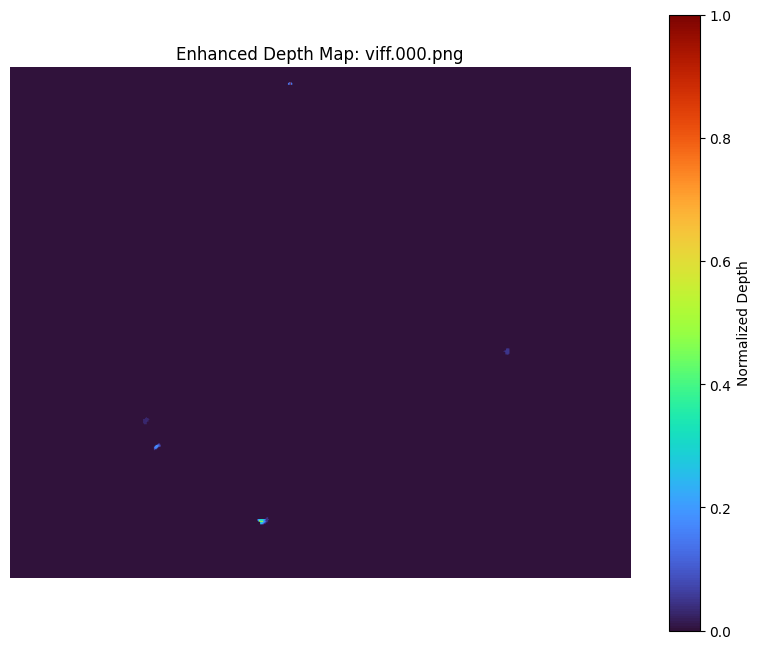

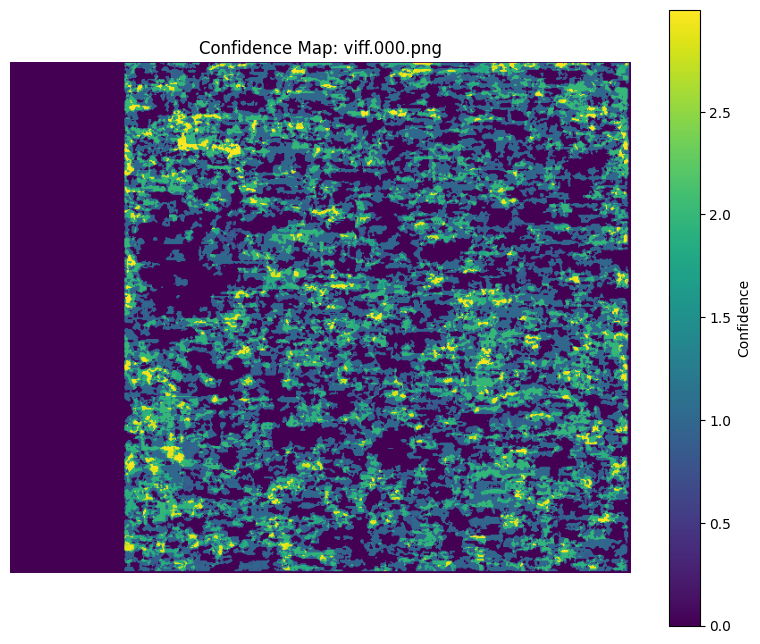


Generating dense point cloud from depth maps...


Creating point cloud:   3%|▎         | 1/36 [00:00<00:04,  8.00it/s]

Added 199 points from viff.000.png


Creating point cloud:   6%|▌         | 2/36 [00:00<00:04,  8.26it/s]

Added 165 points from viff.001.png


Creating point cloud:   8%|▊         | 3/36 [00:00<00:04,  7.96it/s]

Added 80 points from viff.002.png


Creating point cloud:  11%|█         | 4/36 [00:00<00:03,  8.56it/s]

Added 175 points from viff.003.png
Added 26 points from viff.004.png


Creating point cloud:  17%|█▋        | 6/36 [00:00<00:03,  9.93it/s]

Added 124 points from viff.005.png


Creating point cloud:  19%|█▉        | 7/36 [00:00<00:03,  9.66it/s]

Added 95 points from viff.006.png


Creating point cloud:  22%|██▏       | 8/36 [00:00<00:03,  9.19it/s]

Added 113 points from viff.007.png


Creating point cloud:  25%|██▌       | 9/36 [00:01<00:03,  8.71it/s]

Added 151 points from viff.008.png


Creating point cloud:  31%|███       | 11/36 [00:01<00:02,  9.85it/s]

Added 117 points from viff.009.png
Added 184 points from viff.010.png


Creating point cloud:  36%|███▌      | 13/36 [00:01<00:02, 10.61it/s]

Added 130 points from viff.011.png
Added 82 points from viff.012.png
Added 144 points from viff.013.png


Creating point cloud:  42%|████▏     | 15/36 [00:01<00:02,  9.95it/s]

Added 28 points from viff.014.png
Added 126 points from viff.015.png
Added 52 points from viff.016.png

Creating point cloud:  47%|████▋     | 17/36 [00:01<00:01, 10.20it/s]


Added 106 points from viff.017.png
Added 107 points from viff.018.png

Creating point cloud:  56%|█████▌    | 20/36 [00:02<00:01,  9.62it/s]


Added 56 points from viff.019.png
Added 99 points from viff.020.png


Creating point cloud:  67%|██████▋   | 24/36 [00:02<00:01, 10.20it/s]

Added 145 points from viff.021.png
Added 84 points from viff.022.png
Added 38 points from viff.023.png


Creating point cloud:  72%|███████▏  | 26/36 [00:02<00:00, 10.18it/s]

Added 82 points from viff.024.png
Added 67 points from viff.025.png
Added 97 points from viff.026.png


Creating point cloud:  83%|████████▎ | 30/36 [00:03<00:00, 10.27it/s]

Added 54 points from viff.027.png
Added 45 points from viff.028.png
Added 30 points from viff.029.png


Creating point cloud:  89%|████████▉ | 32/36 [00:03<00:00, 10.23it/s]

Added 168 points from viff.030.png
Added 161 points from viff.031.png
Added 172 points from viff.032.png


Creating point cloud:  94%|█████████▍| 34/36 [00:03<00:00, 10.71it/s]

Added 172 points from viff.033.png
Added 128 points from viff.034.png
Added 106 points from viff.035.png


Creating point cloud: 100%|██████████| 36/36 [00:03<00:00,  9.86it/s]


Created point cloud with 3908 points
Original point cloud has 3908 points
Downsampling with voxel size 0.02...
Removing outliers (nb_neighbors=30, std_ratio=2.5)...
Filtered point cloud has 1370 points
Estimating normals...
Computed normals for 1370 points
Performing Poisson surface reconstruction (depth=9)...
Created mesh with 11597 triangles
Final point cloud contains 1370 points.


Saved dense point cloud to ../data/results/dinosaur_dense.ply

Creating mesh from point cloud...
Computing normals with optimized parameters...
Performing Poisson surface reconstruction (depth=9)...
Created mesh with 11626 triangles
Cleaning mesh to improve quality...
Applying final smoothing to improve surface quality...
[Open3D WARNING] Write Ply clamped color value to valid range
Saved mesh to ../data/results/dinosaur_mesh.ply
Saved mesh to ../data/results/dinosaur_mesh.ply


In [29]:
# Significantly modified MVS configuration optimized for challenging objects like dinosaur figurines
improved_mvs_config = {
    'min_disparity': 0,
    'num_disparities': 192,      # Increased for better depth range coverage
    'block_size': 13,            # Larger block for smooth surfaces
    'filter_depths': True,
    'consistency_threshold': 0.18, # Much more permissive threshold for challenging textures
    'num_source_views': 6,       # Use more source views
    'speckle_size': 150,         # Increased speckle filtering
    'speckle_range': 3,          # Slightly increased range
    'uniqueness_ratio': 5,       # Lower ratio to capture more potential matches
    'pre_filter_cap': 31
}

# Run MVS with improved parameters using hybrid approach - both clean and original images
print("\nRunning Multi-View Stereo with hybrid approach...")

# Create hybrid image list that combines black background and original images
hybrid_images = []
for name in camera_poses.keys():
    # First find the original background image
    orig_img = next((img for img, filename in original_images if filename == name), None)
    # Also find the black background image
    black_img = next((img for img, filename in black_images if filename == name), None)
    
    if orig_img is not None and black_img is not None:
        # Create a mask from the black background image
        if len(black_img.shape) == 3:
            gray = cv2.cvtColor(black_img, cv2.COLOR_RGB2GRAY)
        else:
            gray = black_img
        
        # Create binary mask (non-black areas)
        _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
        
        # Add preprocessing to enhance texture
        # Apply CLAHE to original image to enhance texture
        if len(orig_img.shape) == 3:
            lab = cv2.cvtColor(orig_img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            enhanced_lab = cv2.merge((cl, a, b))
            enhanced_orig = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
        else:
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            enhanced_orig = clahe.apply(orig_img)
        
        # Use the original image (with texture enhancement) for MVS
        hybrid_images.append((enhanced_orig, name))
    elif orig_img is not None:
        # Fall back to original if no black background version exists
        hybrid_images.append((orig_img, name))
    elif black_img is not None:
        # Fall back to black background if no original version exists
        hybrid_images.append((black_img, name))

mvs_results = process_mvs(hybrid_images, camera_poses, K, config['mvs'])

# Extract depth maps
depth_maps = mvs_results['filtered_depth_maps']
confidence_maps = mvs_results['confidence_maps']

print(f"Generated {len(depth_maps)} depth maps.")

# Apply additional post-processing to improve depth maps
print("Applying additional depth map enhancement...")
enhanced_depth_maps = {}

for name, depth_map in depth_maps.items():
    # Find valid depths
    valid_mask = depth_map > 0
    
    if np.sum(valid_mask) > 0:
        # Apply median filter to remove noise (with larger kernel)
        filtered_depth = cv2.medianBlur(depth_map, 5)
        
        # Fill small holes using morphological operations
        kernel = np.ones((5, 5), np.uint8)
        valid_mask_filled = cv2.morphologyEx(valid_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        
        # Use a more aggressive bilateral filter to smooth while preserving edges
        smoothed_depth = cv2.bilateralFilter(filtered_depth, 9, 75, 75)
        
        # Combine the results
        enhanced_depth = smoothed_depth.copy()
        
        # Keep only the valid regions after morphological operations
        enhanced_depth[valid_mask_filled == 0] = 0
        
        enhanced_depth_maps[name] = enhanced_depth
    else:
        enhanced_depth_maps[name] = depth_map

# Replace the original depth maps with enhanced ones
depth_maps = enhanced_depth_maps

# Visualize a sample depth map
if len(depth_maps) > 0:
    # Choose a sample depth map
    sample_name = list(depth_maps.keys())[0]
    depth_map = depth_maps[sample_name]
    
    # Normalize depth for visualization
    valid_mask = depth_map > 0
    if np.any(valid_mask):
        min_depth = np.min(depth_map[valid_mask])
        max_depth = np.max(depth_map[valid_mask])
        normalized_depth = np.zeros_like(depth_map)
        normalized_depth[valid_mask] = (depth_map[valid_mask] - min_depth) / (max_depth - min_depth)
        
        # Display depth map with improved color mapping
        plt.figure(figsize=(10, 8))
        plt.imshow(normalized_depth, cmap='turbo')  # Using turbo colormap for better depth visualization
        plt.colorbar(label='Normalized Depth')
        plt.title(f"Enhanced Depth Map: {sample_name}")
        plt.axis('off')
        plt.show()
        
        # Also show the confidence map
        conf_map = confidence_maps[sample_name]
        plt.figure(figsize=(10, 8))
        plt.imshow(conf_map, cmap='viridis')
        plt.colorbar(label='Confidence')
        plt.title(f"Confidence Map: {sample_name}")
        plt.axis('off')
        plt.show()

# Enhanced point cloud settings specifically for challenging objects like dinosaur models
enhanced_point_cloud_config = {
    'voxel_size': 0.02,           # Smaller voxel size for more detail
    'nb_neighbors': 30,           # More neighbors for better outlier detection
    'std_ratio': 2.5,             # More permissive outlier rejection
    'confidence_threshold': 0.3    # Lower threshold to include more points
}

# Generate dense point cloud with size limits
print("\nGenerating dense point cloud from depth maps...")
dense_results = process_dense_reconstruction(
    hybrid_images, camera_poses, K, depth_maps, confidence_maps, enhanced_point_cloud_config)

# Extract results
dense_points = dense_results['filtered_points']
dense_colors = dense_results['filtered_colors']

# Limit point cloud size if needed
if len(dense_points) > 500000:
    print(f"Point cloud too large ({len(dense_points)} points), downsampling to ~500K points...")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    
    # Gradually increase voxel size until points are under 500K
    target_size = 500000
    voxel_size = 0.025
    while len(pcd.points) > target_size and voxel_size < 0.1:
        voxel_size += 0.01
        pcd = pcd.voxel_down_sample(voxel_size)
        print(f"Downsampled to {len(pcd.points)} points with voxel size {voxel_size:.2f}")
    
    dense_points = np.asarray(pcd.points)
    dense_colors = np.asarray(pcd.colors)

if len(dense_points) > 0:
    print(f"Final point cloud contains {len(dense_points)} points.")
    
    # Visualize dense point cloud
    plot_interactive_point_cloud(dense_points, dense_colors, title="Dense 3D Reconstruction")
    
    # Save dense point cloud
    dense_cloud_file = os.path.join(output_dir, "dinosaur_dense.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    o3d.io.write_point_cloud(dense_cloud_file, pcd)
    print(f"Saved dense point cloud to {dense_cloud_file}")
    
    # Create mesh with optimized parameters for dinosaur model
    mesh_config = {
        'method': 'poisson',
        'depth': 9,             # Higher depth for more detail
        'scale': 1.1,           # Slightly aggressive weighing
        'cleanup': True
    }
    
    print("\nCreating mesh from point cloud...")
    # Compute normals with better parameters
    print("Computing normals with optimized parameters...")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    
    # Use more neighbors for smoother normals on the dinosaur surface
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    pcd.orient_normals_consistent_tangent_plane(k=20)
    
    normals = np.asarray(pcd.normals)
    
    # Create mesh
    mesh = create_surface_mesh(
        dense_points, 
        dense_colors, 
        normals,
        method=mesh_config['method'], 
        depth=mesh_config['depth']
    )
    
    if mesh:
        # Clean the mesh
        print("Cleaning mesh to improve quality...")
        mesh = clean_mesh(mesh, detail_level=3)
        
        # Optional: apply Laplacian smoothing to get smoother dinosaur surface
        print("Applying final smoothing to improve surface quality...")
        mesh = mesh.filter_smooth_taubin(number_of_iterations=10)
        
        # Save the mesh
        mesh_file = os.path.join(output_dir, "dinosaur_mesh.ply")
        save_mesh(mesh, mesh_file)
        print(f"Saved mesh to {mesh_file}")
        
        # Visualize the mesh
        visualize_mesh_o3d(mesh, window_name="Dinosaur 3D Mesh")

In [30]:
# Generate mesh from dense point cloud
print("\nGenerating surface mesh...")
mesh, pcd = process_point_cloud_to_mesh(
    dense_points, dense_colors, method=config['surface']['method'])

# Display mesh statistics
print(f"Mesh contains {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles.")

# Visualize mesh (this will open an Open3D window)
print("\nVisualizing mesh (this will open a new window)...")
visualize_mesh_o3d(mesh, window_name="Reconstructed Mesh")

# Save mesh
mesh_file = os.path.join(output_dir, "dinosaur_mesh.ply")
o3d.io.write_triangle_mesh(mesh_file, mesh)
print(f"Saved mesh to {mesh_file}")


Generating surface mesh...
Starting mesh reconstruction from 1370 points using poisson method
Removing statistical outliers...
Point cloud too sparse for downsampling, skipping this step
Estimating normals...
Performing Poisson reconstruction with depth=7...
Cleaning up mesh...
Mesh reconstruction complete: 2313 vertices, 4489 triangles
Mesh contains 2313 vertices and 4489 triangles.

Visualizing mesh (this will open a new window)...
Saved mesh to ../data/results/dinosaur_mesh.ply


In [31]:
# Generate textured mesh
print("\nGenerating textured mesh...")
textured_mesh = create_textured_mesh_from_point_cloud(
    dense_points, dense_colors, images, camera_poses, K, 
    reconstruction_method=config['surface']['method'])

# Visualize textured mesh (this will open an Open3D window)
print("\nVisualizing textured mesh (this will open a new window)...")
visualize_mesh_o3d(textured_mesh, window_name="Textured Mesh")

# Save textured mesh
textured_mesh_file = os.path.join(output_dir, "dinosaur_textured.obj")
o3d.io.write_triangle_mesh(textured_mesh_file, textured_mesh)
print(f"Saved textured mesh to {textured_mesh_file}")


Generating textured mesh...


NameError: name 'images' is not defined

In [ ]:
# Create interactive mesh visualization using Plotly
print("\nCreating interactive mesh visualization...")

# Extract mesh data for Plotly
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)
vertex_colors = np.asarray(mesh.vertex_colors) if mesh.has_vertex_colors() else None

# Create interactive plot
plot_interactive_mesh(vertices, triangles, vertex_colors, title="Interactive 3D Dinosaur Model")

# Create rotating animation (optional)
print("\nCreating 360° animation of the model...")
animation = create_point_cloud_animation(
    dense_points, dense_colors, n_frames=36, 
    output_file=os.path.join(output_dir, "dinosaur_animation.html"))

print("\n3D reconstruction pipeline complete!")
print(f"All results saved to: {output_dir}")

# Display summary of the reconstruction
print("\nReconstruction Summary:")
print(f"Images processed: {len(images)}")
print(f"Camera poses estimated: {len(camera_poses)}")
print(f"Sparse points: {len(points_3d)}")
print(f"Dense points: {len(dense_points)}")
print(f"Mesh vertices: {len(mesh.vertices)}")
print(f"Mesh triangles: {len(mesh.triangles)}")

In [ ]:
# Simplify and optimize mesh for 3D printing (optional)
print("\nOptimizing mesh for export...")

# Make a copy of the mesh for optimization
export_mesh = o3d.geometry.TriangleMesh(mesh)

# Remove any non-manifold edges
export_mesh.remove_non_manifold_edges()

# Fill holes
export_mesh = export_mesh.filter_smooth_simple(5)  # Smooth mesh

# Simplify mesh to reduce polygon count
target_triangles = int(len(export_mesh.triangles) * 0.5)  # Reduce to 50%
export_mesh = export_mesh.simplify_quadric_decimation(target_triangles)

# Fix mesh normals
export_mesh.compute_vertex_normals()

# Save optimized mesh in multiple formats
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.obj"), export_mesh)
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.stl"), export_mesh)

print("Optimized mesh exported in OBJ and STL formats, suitable for 3D printing and other applications.")